#### Vision Transformers Explained Series

# Tokens-to-Token Vision Transformers, Explained

### A Full Walk-Through of the Tokens-to-Token Vision Transformer, and Why It's Better than the Original

*Since their introduction in 2017 with* Attention is All You Need¹, *transformers have established themselves as the state of the art for natural language processing (NLP). In 2021,* An Image is Worth 16x16 Words *successfully adapted transformers for computer vision tasks. Since then, numerous transformer-based architectures have been proposed for computer vision.*

**In 2021, _Tokens-to-Token ViT: Training Vision Transformers from Scratch on ImageNet_ ³ outlined the Tokens-to-Token (T2T) ViT. This model aims to remove the heavy pretraining requirement present in the original ViT². This article walks through the T2T-ViT, including open-source code for T2T-ViT, as well as conceptual explanations of the components. All of the code uses the PyTorch Python package.**

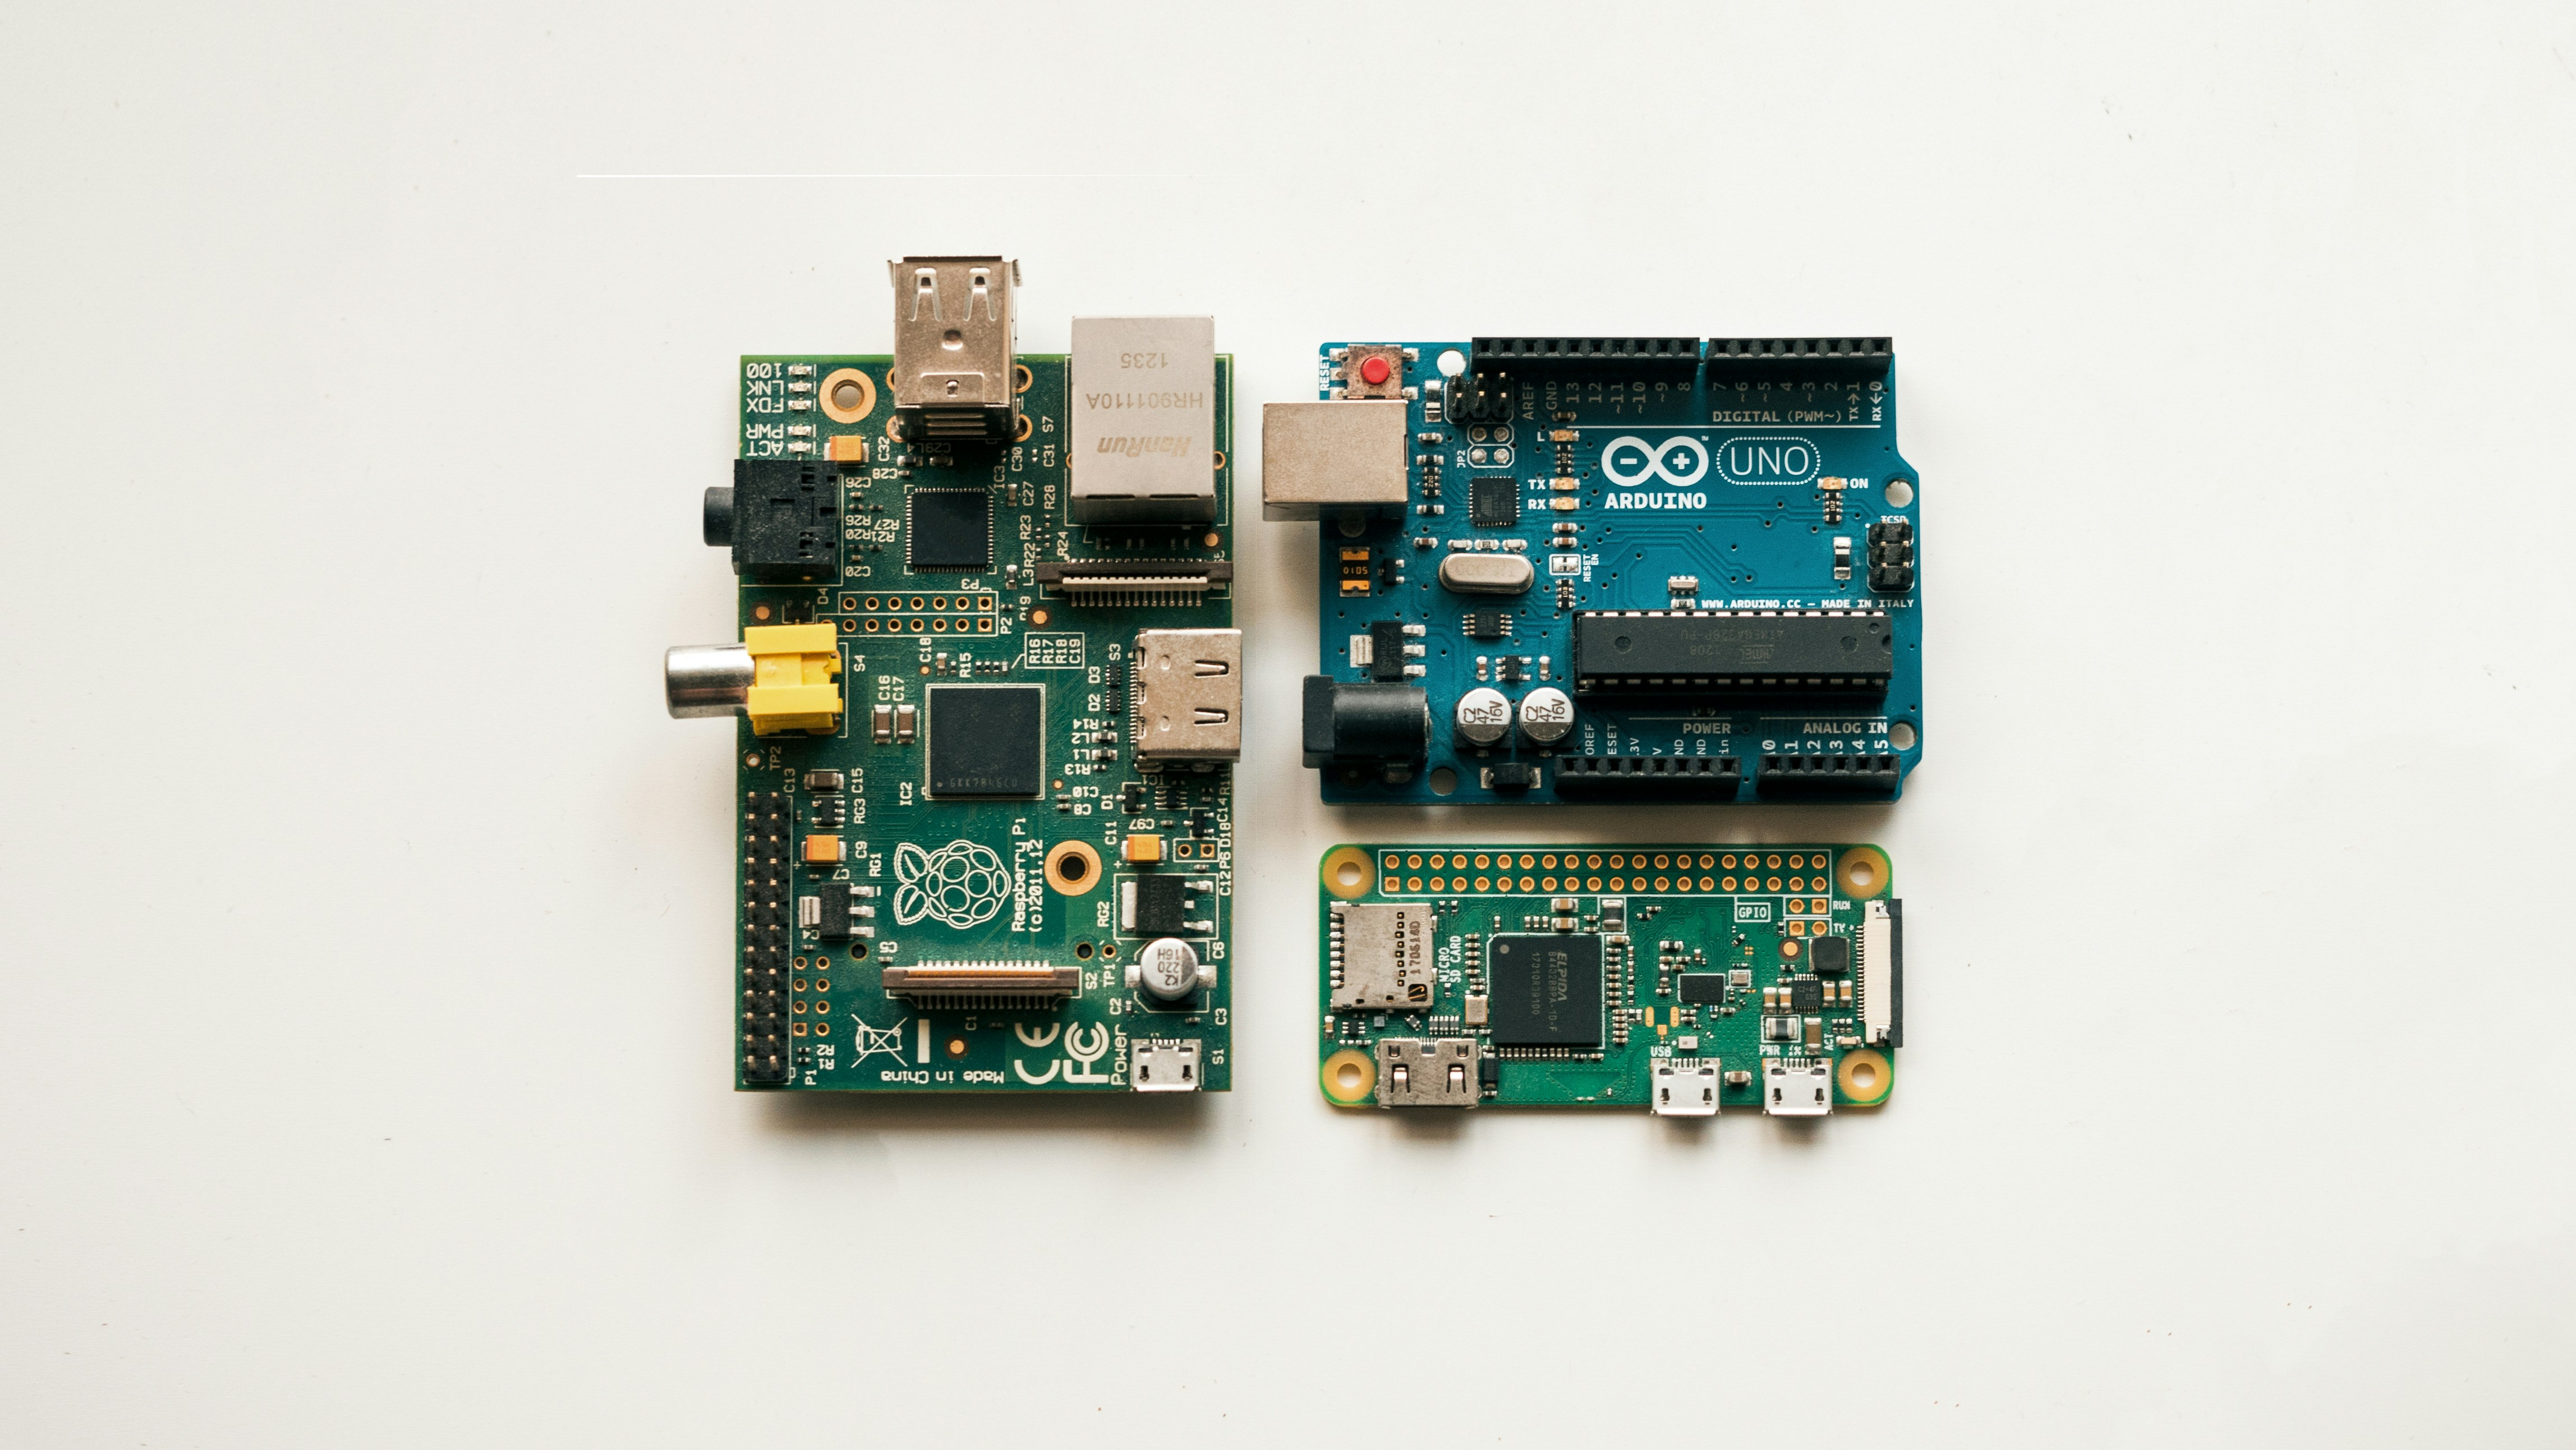

Photo by <a href="https://unsplash.com/@harrisonbroadbent?utm_content=creditCopyText&utm_medium=referral&utm_source=unsplash">Harrison Broadbent</a> on <a href="https://unsplash.com/photos/green-and-black-circuit-board-VOz0gV9HC0I?utm_content=creditCopyText&utm_medium=referral&utm_source=unsplash">Unsplash</a>

This article is part of a collection examining the internal workings of Vision Transformers in depth. Each of these articles is also available as a Jupyter Notebook with executable code. The other articles in the series are:

 - Vision Transformers, Explained
    - Jupyter Notebook
 - Attention for Vision Transformers, Explained
    - Jupyter Notebook
 - Position Embeddings for Vision Transformers, Explained
    - Jupyter Notebook
 - Tokens-to-Token Vision Transformers, Explained
    - **Jupyter Notebook**
 - GitHub Repository for Vision Transformers, Explained Series

In [36]:
import os
import copy
import math
import typing
import cv2
import imageio.v2 as iio
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import timm.layers as timmm 

In [3]:
figure_path = '../figures/NotebookOutput'

In [4]:
NoneFloat = typing.Union[None, float]

## What is Tokens-to-Token ViT?

The first vision transformers able to match the performance of CNNs on computer vision tasks required pre-training on large datasets and then transferring to the benchmark of interest². However, pre-training on such datasets is not always feasible. For one, the pre-training dataset that achieved the best results in *An Image is Worth 16x16 Words* (the JFT-300M dataset) is not publicly available². Furthermore, vistransformers designed for tasks other than traditional image classification may not have such large pre-training datasets available.

In 2021, *Tokens-to-Token ViT: Training Vision Transformers from Scratch on ImageNet*³ was published, presenting a methodology that would circumvent the heavy pre-training requirement of previous vistransformers. They achieved this by replacing the *patch tokenization* in the ViT model² with the a Tokens-to-Token (T2T) module.

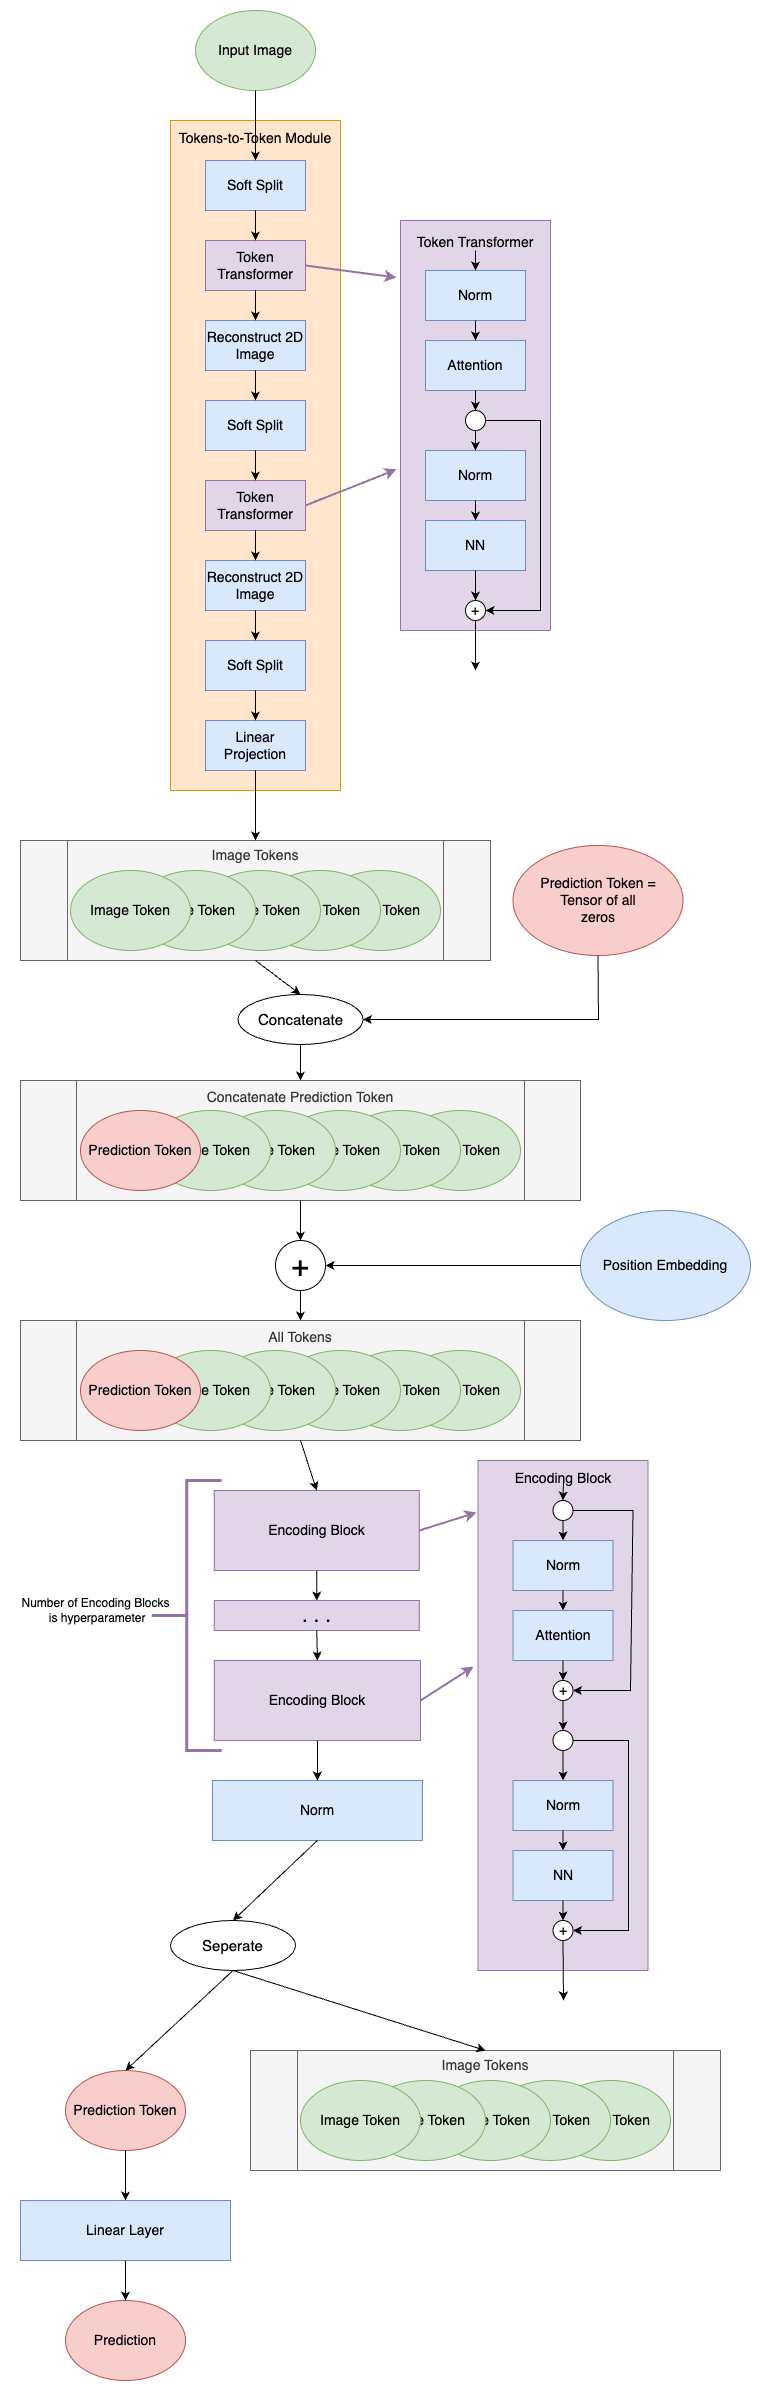

Since the T2T module is what makes the T2T-ViT model unique, it will be the focus of this article. For a deep dive into the ViT components see TK. The code is based on the publicly available GitHub code for *Tokens-to-Token ViT³* with some modifications. Changes to the source code include, but are not limited to, modifying to allow for non-square input images and removing dropout layers.

## Tokens-to-Token (T2T) Module

The T2T module serves to process the input image into tokens that can be used in the ViT module. Instead of simply splitting the input image into patches that become tokens, the T2T module sequentially computes attention between tokens and aggregates them together to capture additional structure in the image and to reduce the overall token length. The T2T module diagram is shown below.

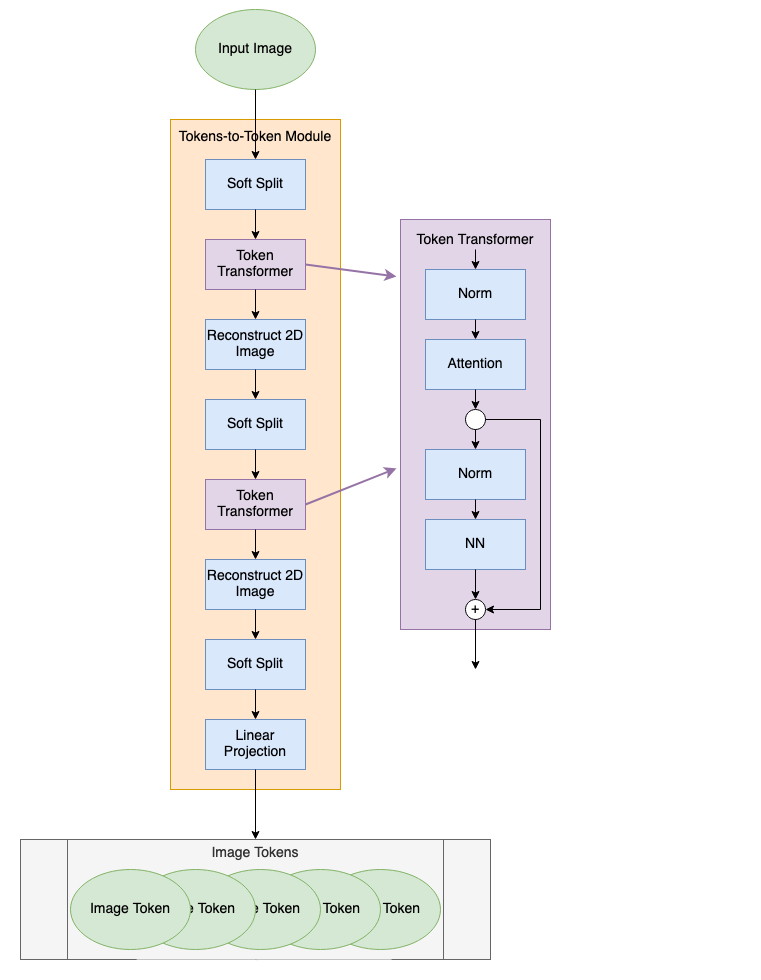

### Soft Split

As the first layer in the T2T-ViT model, the soft split layer is what separates an image into a series of tokens. The soft split layers are shown as blue blocks in the T2T diagram. Unlike the *patch tokenization* in the original ViT (read more about that TK), the soft splits in the T2T-ViT create overlapping patches.

Let's look at an example of the soft split on this pixel art *Mountain at Dusk* by Luis Zuno (@ansimuz)⁴. The original artwork has been cropped and converted to a single channel image. This means that each pixel has a value between zero and one. Single channel images are typically displayed in grayscale; however, we'll be displaying it in a purple color scheme because its easier to see.

Mountain at Dusk is H = 60 and W = 100 pixels.




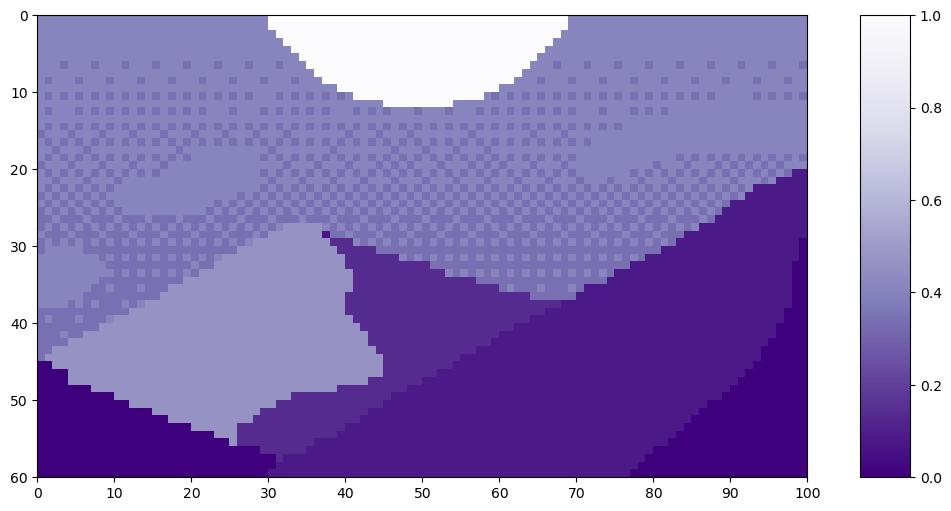

In [5]:
mountains = np.load(os.path.join(figure_path, 'mountains.npy'))

H = mountains.shape[0]
W = mountains.shape[1]
print('Mountain at Dusk is H =', H, 'and W =', W, 'pixels.')
print('\n')

fig = plt.figure(figsize=(10,6))
plt.imshow(mountains, cmap='Purples_r')
plt.xticks(np.arange(-0.5, W+1, 10), labels=np.arange(0, W+1, 10))
plt.yticks(np.arange(-0.5, H+1, 10), labels=np.arange(0, H+1, 10))
plt.clim([0,1])
cbar_ax = fig.add_axes([0.95, .11, 0.05, 0.77])
plt.clim([0, 1])
plt.colorbar(cax=cbar_ax);
#plt.savefig(os.path.join(figure_path, 'mountains.png'), bbox_inches='tight')

This image has size $H=60$ and $W=100$. We'll use a patch size - or equivalently *kernel* -  of $k=20$. T2T-ViT sets the *stride* - a measure of overlap - at $s=ceil(\frac{k}{2})$ and the *padding* at $p=ceil(\frac{k}{4})$. For our example, that means we'll use $s=10$ and $p=5$. The padding is all zero values, which appear as the darkest purple.

Before we can look at the patches created in the soft split, we have to know how many patches there will be. The soft splits are implemented as `torch.nn.Unfold`⁵ layers. To calculate how many tokens the soft split will create, we use the following formula:

$$num\_tokens = \lfloor \frac{h + 2*p - (k-1) -1}{s} +1 \rfloor * \lfloor \frac{w + 2*p - (k-1) -1}{s} +1 \rfloor$$

where $h$ is the original image height, $w$ is the original image width, $k$ is the kernel size, $s$ is the stride size, and $p$ is the padding size⁵. This formula assumes the kernel is square, and that the stride and padding are symmetric. Additionally, it assumes that dilation is 1.

***An aside about dilation**: PyTorch describes dilation as "control[ling] the spacing between the kernel points"⁵, and refers readers to the diagram [here](https://github.com/vdumoulin/conv_arithmetic/blob/master/README.md). A dilation=1 value keeps the kernel as you would expect, all pixels touching. A user in [this forum](https://discuss.pytorch.org/t/why-the-default-dilation-value-in-conv2d-is-1/5612) suggests to think about it as "every `dilation`-th element is used." In this case, every 1st element is used, meaning every element is used.*

The first term in the $num\_tokens$ equation describes how many tokens are along the height, while the second term describes how many tokens are along the width. We implement this in code below:

In [21]:
def count_tokens(w, h, k, s, p):
	""" Function to count how many tokens are produced from a given soft split

		Args:
			w (int): starting width
			h (int): starting height
			k (int): kernel size
			s (int): stride size
			p (int): padding size

		Returns:
			new_w (int): number of tokens along the width
			new_h (int): number of tokens along the height
			total (int): total number of tokens created
	"""

	new_w = int(math.floor(((w + 2*p -1*(k-1) -1)/s)+1))
	new_h = int(math.floor(((h + 2*p -1*(k-1) -1)/s)+1))
	total = new_w * new_h

	return new_w, new_h, total

Using the dimensions in the *Mountain at Dusk*⁴ example:

In [24]:
k = 20
s = 10
p = 5
padded_H = H + 2*p
padded_W = W + 2*p
print('With padding, the image will be H =', padded_H, 'and W =', padded_W, 'pixels.\n') 

patches_w, patches_h, total_patches = count_tokens(w=W, h=H, k=k, s=s, p=p)
print('There will be', total_patches, 'patches as a result of the soft split;')
print(patches_h, 'along the height and', patches_w, 'along the width.')

With padding, the image will be H = 70 and W = 110 pixels.

There will be 60 patches as a result of the soft split;
6 along the height and 10 along the width.


Now, we can see how the soft split creates patches from *Mountain at Dusk*⁴.

In [56]:
mountains_w_padding = np.pad(mountains, pad_width = ((p, p), (p, p)), mode='constant', constant_values=0)

left_x = np.tile(np.arange(-0.5, padded_W-k+1, s), patches_h)
right_x = np.tile(np.arange(k-0.5, padded_W+1, s), patches_h)
top_y = np.repeat(np.arange(-0.5, padded_H-k+1, s), patches_w)
bottom_y = np.repeat(np.arange(k-0.5, padded_H+1, s), patches_w)

frame_paths = []

for i in range(total_patches):
    fig = plt.figure(figsize=(10,6))
    plt.imshow(mountains_w_padding, cmap='Purples_r')
    plt.clim([0,1])
    plt.xticks(np.arange(-0.5, W+2*p+1, 10), labels=np.arange(0, W+2*p+1, 10))
    plt.yticks(np.arange(-0.5, H+2*p+1, 10), labels=np.arange(0, H+2*p+1, 10))

    plt.plot([left_x[i], left_x[i], right_x[i], right_x[i], left_x[i]], [top_y[i], bottom_y[i], bottom_y[i], top_y[i], top_y[i]], color='w', lw=3, ls='-')

    for j in range(i):
        plt.plot([left_x[j], left_x[j], right_x[j], right_x[j], left_x[j]], [top_y[j], bottom_y[j], bottom_y[j], top_y[j], top_y[j]], color='w', lw=2, ls=':', alpha=0.5)
    save_path = os.path.join(figure_path, 'softsplit_gif', 'frame{:02d}'.format(i))+'.png'
    frame_paths.append(save_path)
    #fig.savefig(save_path, bbox_inches='tight')
    plt.close()
    
frames = []
for path in frame_paths:
    frames.append(iio.imread(path))

#iio.mimsave(os.path.join(figure_path, 'softsplit.gif'), frames, fps=2, loop=0)

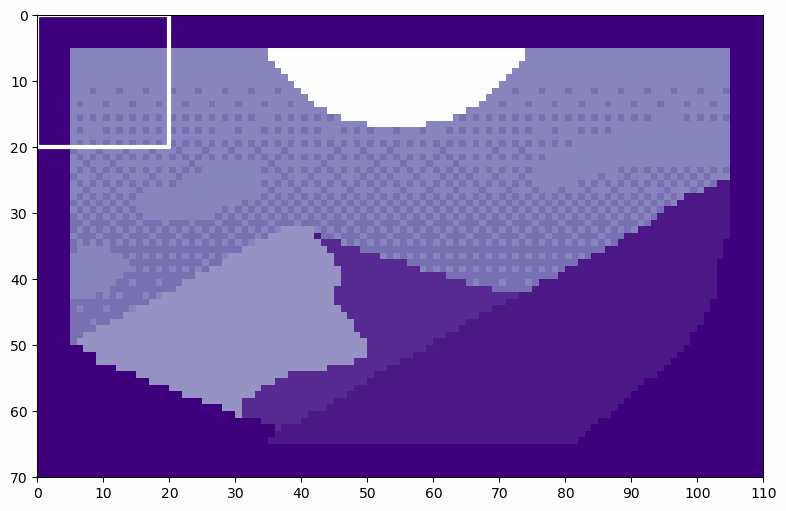

We can see how the soft split results in overlapping patches. By counting the patches as they move across the image, we can see that there are 6 patches along the height and 10 patches along the width, exactly as predicted. By flattening these patches, we see the resulting tokens. Let's flatten the first patch as an example.

Each patch will make a token of length 400.




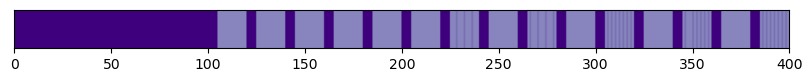

In [63]:
print('Each patch will make a token of length', str(k**2)+'.')
print('\n')

patch = mountains_w_padding[0:20, 0:20]
token = patch.reshape(1, k**2,)

fig = plt.figure(figsize=(10,1))
plt.imshow(token, cmap='Purples_r', aspect=20)
plt.clim([0, 1])
plt.xticks(np.arange(-0.5, k**2+1, 50), labels=np.arange(0, k**2+1, 50))
plt.yticks([]);
#plt.savefig(os.path.join(figure_path, 'mountains_w_padding_token01.png'), bbox_inches='tight')

You can see where the padding shows up in the token!

When passed to the next layer, all of the tokens are aggregated together in a matrix. That matrix looks like:

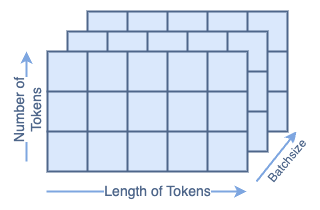

For *Mountain at Dusk*⁴ that would look like:

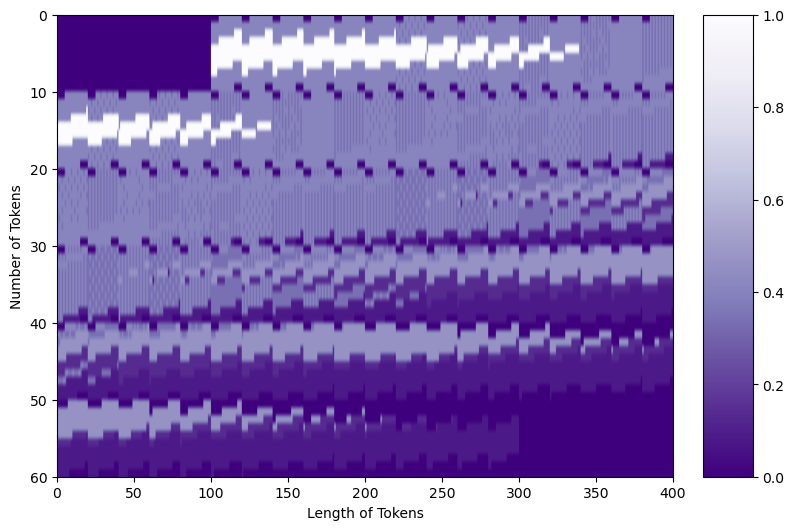

In [75]:
left_x = np.tile(np.arange(0, padded_W-k+1, s), patches_h)
right_x = np.tile(np.arange(k, padded_W+1, s), patches_h)
top_y = np.repeat(np.arange(0, padded_H-k+1, s), patches_w)
bottom_y = np.repeat(np.arange(k, padded_H+1, s), patches_w)

tokens = np.zeros((total_patches, k**2))
for i in range(total_patches):
    patch = mountains_w_padding[top_y[i]:bottom_y[i], left_x[i]:right_x[i]]
    tokens[i, :] = patch.reshape(1, k**2)
    
fig = plt.figure(figsize=(10,6))
plt.imshow(tokens, cmap='Purples_r', aspect=5)
plt.clim([0, 1])
plt.xticks(np.arange(-0.5, k**2+1, 50), labels=np.arange(0, k**2+1, 50))
plt.yticks(np.arange(-0.5, total_patches+1, 10), labels=np.arange(0, total_patches+1, 10))
plt.xlabel('Length of Tokens')
plt.ylabel('Number of Tokens')
plt.clim([0,1])
cbar_ax = fig.add_axes([0.85, .11, 0.05, 0.77])
plt.clim([0, 1])
plt.colorbar(cax=cbar_ax);
#plt.savefig(os.path.join(figure_path, 'mountains_w_padding_tokens_matrix.png'), bbox_inches='tight')

You can see the large areas of padding in the top left and bottom right of the matrix, as well as in smaller segments throughout. Now, our tokens are ready to be passed along to the next step.

### Token Transformer Prerequisite Code

The following code must be executed before the code in the *Token Transformer* section can be run. 

In [76]:
class Attention(nn.Module):
    def __init__(self, 
                dim: int,
                chan: int,
                num_heads: int=1,
                qkv_bias: bool=False,
                qk_scale: NoneFloat=None):

        """ Attention Module

            Args:
                dim (int): input size of a single token
                chan (int): resulting size of a single token (channels)
                num_heads(int): number of attention heads in MSA (only works if =1)
                qkv_bias (bool): determines if the qkv layer learns an addative bias
                qk_scale (NoneFloat): value to scale the queries and keys by; 
                                    if None, queries and keys are scaled by ``head_dim ** -0.5``
        """

        super().__init__()

        ## Define Constants
        self.num_heads = num_heads
        self.chan = chan
        self.head_dim = self.chan // self.num_heads
        self.scale = qk_scale or self.head_dim ** -0.5

        ## Define Layers
        self.qkv = nn.Linear(dim, chan * 3, bias=qkv_bias)
        ## Each token gets projected from starting token_len to channel length 3 times (once for each Q,K,V)
        self.proj = nn.Linear(chan, chan)

    def forward(self, x):
        if self.chan % self.num_heads != 0:
            raise ValueError('"Chan" must be evenly divisible by "num_heads".')
        B, N, C = x.shape
        ## Dimensions: (batch, num_tokens, token_len)

        ## Calcuate QKVs
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, self.head_dim).permute(2, 0, 3, 1, 4)
        ## Dimensions: (qkv, batch, heads, num_tokens, token_len = chan/num_heads = head_dim)
        q, k, v = qkv[0], qkv[1], qkv[2]

        ## Calculate Attention
        attn = (q * self.scale) @ k.transpose(-2, -1)
        attn = attn.softmax(dim=-1)
        ## Dimensions: (batch, heads, num_tokens, num_tokens)

        ## Attention Layer
        x = (attn @ v).transpose(1, 2).reshape(B, N, self.chan)
        ## Dimensions: (batch, heads, num_tokens, token_len = chan)

        ## Projection Layers
        x = self.proj(x)

        ## Skip Connection Layer
        v = v.transpose(1, 2).reshape(B, N, self.chan)
        x = v + x     
        ## Because the original x has different size with current x, use v to do skip connection

        return x

In [77]:
class NeuralNet(nn.Module):
    def __init__(self,
    			in_chan: int,
    			hidden_chan: NoneFloat=None,
    			out_chan: NoneFloat=None,
    			act_layer = nn.GELU):
        """ Neural Network Module

            Args:
                in_chan (int): number of channels (features) at input
                hidden_chan (NoneFloat): number of channels (features) in the hidden layer;
                                        if None, number of channels in hidden layer is the same as the number of input channels
                out_chan (NoneFloat): number of channels (features) at output;
                                        if None, number of output channels is same as the number of input channels
                act_layer(nn.modules.activation): torch neural network layer class to use as activation
        """

        super().__init__()

        ## Define Number of Channels
        hidden_chan = hidden_chan or in_chan
        out_chan = out_chan or in_chan

        ## Define Layers
        self.fc1 = nn.Linear(in_chan, hidden_chan)
        self.act = act_layer()
        self.fc2 = nn.Linear(hidden_chan, out_chan)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.fc2(x)
        return x

### Token Transformer

The next component of the T2T module is the Token Transformer, which is represented by the purple blocks.

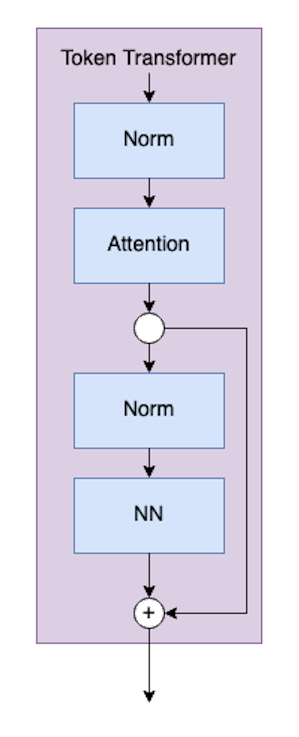

The code for the Token Transformer class looks like:

In [78]:
class TokenTransformer(nn.Module):

    def __init__(self,
       dim: int,
       chan: int,
       num_heads: int,
       hidden_chan_mul: float=1.,
       qkv_bias: bool=False,
       qk_scale: NoneFloat=None,
       act_layer=nn.GELU,
       norm_layer=nn.LayerNorm):

        """ Token Transformer Module

            Args:
                dim (int): size of a single token
                chan (int): resulting size of a single token 
                num_heads (int): number of attention heads in MSA 
                hidden_chan_mul (float): multiplier to determine the number of hidden channels (features) in the NeuralNet module
                qkv_bias (bool): determines if the attention qkv layer learns an addative bias
                qk_scale (NoneFloat): value to scale the queries and keys by; 
                                    if None, queries and keys are scaled by ``head_dim ** -0.5``
                act_layer(nn.modules.activation): torch neural network layer class to use as activation in the NeuralNet module
                norm_layer(nn.modules.normalization): torch neural network layer class to use as normalization
        """

        super().__init__()

        ## Define Layers
        self.norm1 = norm_layer(dim)
        self.attn = Attention(dim,
              chan=chan,
              num_heads=num_heads,
              qkv_bias=qkv_bias,
              qk_scale=qk_scale)
        self.norm2 = norm_layer(chan)
        self.neuralnet = NeuralNet(in_chan=chan,
              hidden_chan=int(chan*hidden_chan_mul),
              out_chan=chan,
              act_layer=act_layer)

    def forward(self, x):
        x = self.attn(self.norm1(x))
        x = x + self.neuralnet(self.norm2(x))
        return x

The *chan*, *num_heads*, *qkv_bias*, and *qk_scale* parameters define the *Attention* module components. A deep dive into attention for vistransformers is beyond the scope of this article. TK contains that.

The *hidden_chan_mul* and *act_layer* parameters define the *Neural Network* module components. The activation layer can be any `torch.nn.modules.activation`⁶ layer. The *norm_layer* can be chosen from any `torch.nn.modules.normalization`⁷ layer.

Let's step through each blue block in the diagram. We're using $7*7=49$ as our starting token size, since the fist soft split has a default kernel of 7x7.³ We're using 64 channels because that's also the default³. We're using 100 tokens because it's a nice number. We're using a batch size of 13 because it's prime and won't be confused for any of the other parameters. We're using 4 heads because it divides the channels; however, you won't see the head dimension in the Token Transformer Module.

In [79]:
# Define an Input
token_len = 7*7
channels = 64
num_tokens = 100
batch = 13
heads = 4
x = torch.rand(batch, num_tokens, token_len)
print('Input dimensions are\n\tbatchsize:', x.shape[0], '\n\tnumber of tokens:', x.shape[1], '\n\ttoken size:', x.shape[2])

# Define the Module
TT = TokenTransformer(dim=token_len, 
                      chan=channels, 
                      num_heads=heads, 
                      hidden_chan_mul=1.5, 
                      qkv_bias=False, 
                      qk_scale=None, 
                      act_layer=nn.GELU, 
                      norm_layer=nn.LayerNorm)
TT.eval();

Input dimensions are
	batchsize: 13 
	number of tokens: 100 
	token size: 49


First, we pass the input through a norm layer, which does not change it's shape. Next, it gets passed through the first *Attention* module, which changes the length of the tokens. Recall that a more in-depth explanation for Attention in VisTransformers can be found TK.

In [80]:
x = TT.norm1(x)
print('After norm, dimensions are\n\tbatchsize:', x.shape[0], '\n\tnumber of tokens:', x.shape[1], '\n\ttoken size:', x.shape[2])
x = TT.attn(x)
print('After attention, dimensions are\n\tbatchsize:', x.shape[0], '\n\tnumber of tokens:', x.shape[1], '\n\ttoken size:', x.shape[2])

After norm, dimensions are
	batchsize: 13 
	number of tokens: 100 
	token size: 49
After attention, dimensions are
	batchsize: 13 
	number of tokens: 100 
	token size: 64


Now, we must save the state for a split connection layer. In the actual class definition, this is done more efficiently in one line. However, for this walk through, we do it separately.

Next, we can pass it through another norm layer and then the *Neural Network* module. The norm layer doesn't change the shape of the input. The neural network is configured to also not change the shape.

The last step is the split connection, which also does not change the shape.

In [81]:
y = TT.norm2(x)
print('After norm, dimensions are\n\tbatchsize:', x.shape[0], '\n\tnumber of tokens:', x.shape[1], '\n\ttoken size:', x.shape[2])
y = TT.neuralnet(y)
print('After neural net, dimensions are\n\tbatchsize:', x.shape[0], '\n\tnumber of tokens:', x.shape[1], '\n\ttoken size:', x.shape[2])
y = y + x
print('After split connection, dimensions are\n\tbatchsize:', x.shape[0], '\n\tnumber of tokens:', x.shape[1], '\n\ttoken size:', x.shape[2])

After norm, dimensions are
	batchsize: 13 
	number of tokens: 100 
	token size: 64
After neural net, dimensions are
	batchsize: 13 
	number of tokens: 100 
	token size: 64
After split connection, dimensions are
	batchsize: 13 
	number of tokens: 100 
	token size: 64


That's all for the Token Transformer Module.

### Neural Network Module

The neural network (NN) module is a sub-component of the token transformer module. The neural network module is very simple, consisting of a fully-connected layer, an activation layer, and another fully-connected layer. The activation layer can be any `torch.nn.modules.activation`⁶ layer, which is passed as input to the module. The NN module can be configured to change the shape of an input, or to maintain the same shape. We're not going to step through this code, as NNs are common in machine learning, and not the focus of this article. However, the code for the NN module is presented below.

In [82]:
class NeuralNet(nn.Module):
    def __init__(self,
       in_chan: int,
       hidden_chan: NoneFloat=None,
       out_chan: NoneFloat=None,
       act_layer = nn.GELU):
        """ Neural Network Module

            Args:
                in_chan (int): number of channels (features) at input
                hidden_chan (NoneFloat): number of channels (features) in the hidden layer;
                                        if None, number of channels in hidden layer is the same as the number of input channels
                out_chan (NoneFloat): number of channels (features) at output;
                                        if None, number of output channels is same as the number of input channels
                act_layer(nn.modules.activation): torch neural network layer class to use as activation
        """

        super().__init__()

        ## Define Number of Channels
        hidden_chan = hidden_chan or in_chan
        out_chan = out_chan or in_chan

        ## Define Layers
        self.fc1 = nn.Linear(in_chan, hidden_chan)
        self.act = act_layer()
        self.fc2 = nn.Linear(hidden_chan, out_chan)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.fc2(x)
        return x

### Image Reconstruction

The image reconstruction layers are also shown as blue blocks inside the T2T diagram. The shape of the input to the reconstruction layers looks like (batch, num_tokens, tokensize=channels). If we look at just one batch, that looks like this:

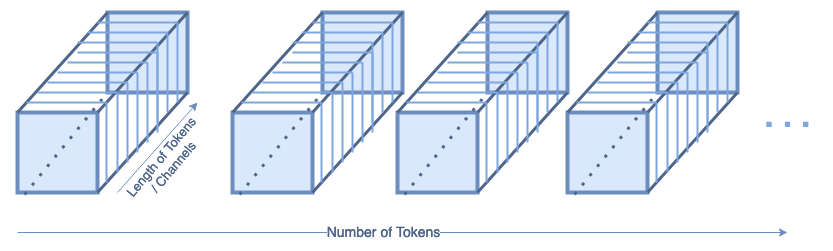

The reconstruction layers reshape the tokens into a 2D image again, which looks like this:

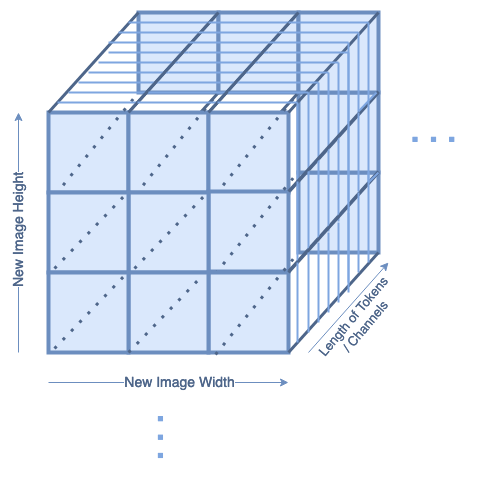

In each batch, there will be *tokensize = channel* number of reconstructed images. This is handled in the same way as if the image was in color, and had three color channels.

The code for reconstruction isn't wrapped in it's own function. However, an example is shown below:

```
W, H, _ = count_tokens(w, h, k, s, p)
x = x.transpose(1,2).reshape(B, C, H, W)
```

### All Together

Now we're ready to examine the whole T2T module put together! The model class for the T2T module looks like:

In [95]:
class Tokens2Token(nn.Module):
    def __init__(self, 
                img_size: tuple[int, int, int]=(1, 1000, 300), 
                token_chan:  int=64,
                token_len: int=768,):
    
        """ Tokens-to-Token Module
            Args:
                img_size (tuple[int, int, int]): size of input (channels, height, width)
                token_chan (int): number of token channels inside the TokenTransformers
                token_len (int): desired length of an output token
        """

        super().__init__()

        ## Seperating Image Size
        C, H, W = img_size
        self.token_chan = token_chan
        ## Dimensions: (channels, height, width)

        ## Define the Soft Split Layers
        self.soft_split0 = nn.Unfold(kernel_size=(7, 7), stride=(4, 4), padding=(2, 2))
        self.soft_split1 = nn.Unfold(kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        self.soft_split2 = nn.Unfold(kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))

        ## Determining Number of Output Tokens
        W, H, _ = count_tokens(w=W, h=H, k=7, s=4, p=2)
        W, H, _ = count_tokens(w=W, h=H, k=3, s=2, p=1)
        _, _, T = count_tokens(w=W, h=H, k=3, s=2, p=1)
        self.num_tokens = T


        ## Define the Transformer Layers
        self.transformer1 = TokenTransformer(dim= C * 7 * 7, 
        chan=token_chan,
        num_heads=1,
        hidden_chan_mul=1.0)
        self.transformer2 = TokenTransformer(dim=token_chan * 3 * 3, 
        chan=token_chan, 
        num_heads=1, 
        hidden_chan_mul=1.0)

        ## Define the Projection Layer
        self.project = nn.Linear(token_chan * 3 * 3, token_len)
  
    def forward(self, x):

        B, C, H, W = x.shape
        ## Dimensions: (batch, channels, height, width)

        ## Initial Soft Split
        x = self.soft_split0(x).transpose(1, 2)

        ## Token Transformer 1
        x = self.transformer1(x)

        ## Reconstruct 2D Image
        W, H, _ = count_tokens(w=W, h=H, k=7, s=4, p=2)
        x = x.transpose(1,2).reshape(B, self.token_chan, H, W)

        ## Soft Split 1
        x = self.soft_split1(x).transpose(1, 2)

        ## Token Transformer 2
        x = self.transformer2(x)

        ## Reconstruct 2D Image
        W, H, _ = count_tokens(w=W, h=H, k=3, s=2, p=1)
        x = x.transpose(1,2).reshape(B, self.token_chan, H, W)

        ## Soft Split 2
        x = self.soft_split2(x).transpose(1, 2)

        ## Project Tokens to desired length
        x = self.project(x)

        return x

Let's walk through the forward pass. Since we already examined the components in more depth, this section will treat them as black boxes: we'll just be looking at the input and outputs.

We'll define an input to the network of shape 1x400x100 to represent a grayscale (one channel) rectangular image. We're using 64 channels and 768 token length because those are the default values³. We're using a batch size of 13 because it's prime and won't be confused for any of the other parameters.

In [113]:
# Define an Input
H = 400
W = 100
channels = 64
batch = 13
x = torch.rand(batch, 1, H, W)
print('Input dimensions are\n\tbatchsize:', x.shape[0], '\n\tnumber of input channels:', x.shape[1], '\n\timage size:', (x.shape[2], x.shape[3]))

# Define the Module
T2T = Tokens2Token(img_size=(1, H, W), token_chan=64, token_len=768)
T2T.eval();

Input dimensions are
	batchsize: 13 
	number of input channels: 1 
	image size: (400, 100)


The input image is first passed through a soft split layer with $kernel = 7$, $stride = 4$, and $padding = 2$. The length of the tokens will be the kernel size ($7*7=49$) times the number of channels (= 1 for grayscale input). We can use the `count_tokens` function to calculate how many tokens there should be after the soft split.

In [114]:
# Count Tokens
k = 7
s = 4
p = 2
_, _, T = count_tokens(w=W, h=H, k=k, s=s, p=p)
print('There should be', T, 'tokens after the soft split.')
print('They should be of length', k, '*', k, '* 1 =', k*k*1)

# Perform the Soft Split
x = T2T.soft_split0(x)
print('Dimensions after soft split are\n\tbatchsize:', x.shape[0], '\n\ttoken length:', x.shape[1], '\n\tnumber of tokens:', x.shape[2])
x = x.transpose(1, 2)

There should be 2500 tokens after the soft split.
They should be of length 7 * 7 * 1 = 49
Dimensions after soft split are
	batchsize: 13 
	token length: 49 
	number of tokens: 2500


Next, we pass through the first *Token Transformer*. This does not impact the batch size or number of tokens, but it changes the length of the tokens to be *channels* = 64.

In [115]:
x = T2T.transformer1(x)
print('Dimensions after transformer are\n\tbatchsize:', x.shape[0], '\n\tnumber of tokens:', x.shape[1], '\n\ttoken length:', x.shape[2])

Dimensions after transformer are
	batchsize: 13 
	number of tokens: 2500 
	token length: 64


Now, we reconstruct the tokens back into a 2D image. The `count_tokens` function again can tell us the shape of the new image. It will have 64 channels, the same as the length of the tokens coming out of the *Token Transformer*.

In [116]:
W, H, _ = count_tokens(w=W, h=H, k=k, s=s, p=p)
print('The reconstructed image should have shape', (H, W))

x = x.transpose(1,2).reshape(batch, T2T.token_chan, H, W)
print('Dimensions of reconstructed image are\n\tbatchsize:', x.shape[0], '\n\tnumber of input channels:', x.shape[1], '\n\timage size:', (x.shape[2], x.shape[3]))

The reconstructed image should have shape (100, 25)
Dimensions of reconstructed image are
	batchsize: 13 
	number of input channels: 64 
	image size: (100, 25)


Now that we have a 2D image again, we go back to the soft split! The next code block goes through the second soft split, the second *Token Transformer*, and the second image reconstruction.

In [117]:
# Soft Split
k = 3
s = 2
p = 1
_, _, T = count_tokens(w=W, h=H, k=k, s=s, p=p)
print('There should be', T, 'tokens after the soft split.')
print('They should be of length', k, '*', k, '*', T2T.token_chan, '=', k*k*T2T.token_chan)
x = T2T.soft_split1(x)
print('Dimensions after soft split are\n\tbatchsize:', x.shape[0], '\n\ttoken length:', x.shape[1], '\n\tnumber of tokens:', x.shape[2])
x = x.transpose(1, 2)

# Token Transformer
x = T2T.transformer2(x)
print('Dimensions after transformer are\n\tbatchsize:', x.shape[0], '\n\tnumber of tokens:', x.shape[1], '\n\ttoken length:', x.shape[2])

# Reconstruction
W, H, _ = count_tokens(w=W, h=H, k=k, s=s, p=p)
print('The reconstructed image should have shape', (H, W))
x = x.transpose(1,2).reshape(batch, T2T.token_chan, H, W)
print('Dimensions of reconstructed image are\n\tbatchsize:', x.shape[0], '\n\tnumber of input channels:', x.shape[1], '\n\timage size:', (x.shape[2], x.shape[3]))

There should be 650 tokens after the soft split.
They should be of length 3 * 3 * 64 = 576
Dimensions after soft split are
	batchsize: 13 
	token length: 576 
	number of tokens: 650
Dimensions after transformer are
	batchsize: 13 
	number of tokens: 650 
	token length: 64
The reconstructed image should have shape (50, 13)
Dimensions of reconstructed image are
	batchsize: 13 
	number of input channels: 64 
	image size: (50, 13)


From this reconstructed image, we go through a final soft split. Recall that the output of the T2T module should be a list of tokens.

In [118]:
# Soft Split
k = 3
s = 2
p = 1
_, _, T = count_tokens(w=W, h=H, k=k, s=s, p=p)
print('There should be', T, 'tokens after the soft split.')
print('They should be of length', k, '*', k, '*', T2T.token_chan, '=', k*k*T2T.token_chan)
x = T2T.soft_split2(x)
print('Dimensions after soft split are\n\tbatchsize:', x.shape[0], '\n\ttoken length:', x.shape[1], '\n\tnumber of tokens:', x.shape[2])
x = x.transpose(1, 2)

There should be 175 tokens after the soft split.
They should be of length 3 * 3 * 64 = 576
Dimensions after soft split are
	batchsize: 13 
	token length: 576 
	number of tokens: 175


The last layer in the T2T module is a linear layer to project the tokens to the desired output size. We specified that as $token\_len=768$.

In [119]:
x = T2T.project(x)
print('Output dimensions are\n\tbatchsize:', x.shape[0], '\n\tnumber of tokens:', x.shape[1], '\n\ttoken length:', x.shape[2])

Output dimensions are
	batchsize: 13 
	number of tokens: 175 
	token length: 768


And that concludes the T2T Module!

## ViT Backbone

From the T2T module, the tokens proceed through a ViT backbone. This is identical to the backbone of the ViT model described in [2]. Article TK does an in-depth walk through of the ViT model and the ViT backbone. The code is reproduced below, but we won't do a walk-through. Check that out TK and then come back here!

In [120]:
class Encoding(nn.Module):

    def __init__(self,
       dim: int,
       num_heads: int=1,
       hidden_chan_mul: float=4.,
       qkv_bias: bool=False,
       qk_scale: NoneFloat=None,
       act_layer=nn.GELU, 
       norm_layer=nn.LayerNorm):
        
        """ Encoding Block

            Args:
                dim (int): size of a single token
                num_heads(int): number of attention heads in MSA
                hidden_chan_mul (float): multiplier to determine the number of hidden channels (features) in the NeuralNet component
                qkv_bias (bool): determines if the qkv layer learns an addative bias
                qk_scale (NoneFloat): value to scale the queries and keys by; 
                                    if None, queries and keys are scaled by ``head_dim ** -0.5``
                act_layer(nn.modules.activation): torch neural network layer class to use as activation
                norm_layer(nn.modules.normalization): torch neural network layer class to use as normalization
        """

        super().__init__()

        ## Define Layers
        self.norm1 = norm_layer(dim)
        self.attn = Attention(dim=dim,
                            chan=dim,
                            num_heads=num_heads,
                            qkv_bias=qkv_bias,
                            qk_scale=qk_scale)
        self.norm2 = norm_layer(dim)
        self.neuralnet = NeuralNet(in_chan=dim,
                                hidden_chan=int(dim*hidden_chan_mul),
                                out_chan=dim,
                                act_layer=act_layer)

    def forward(self, x):
        x = x + self.attn(self.norm1(x))
        x = x + self.neuralnet(self.norm2(x))
        return x

In [121]:
class ViT_Backbone(nn.Module):
    def __init__(self,
                preds: int=1,
                token_len: int=768,
                num_heads: int=1,
                Encoding_hidden_chan_mul: float=4.,
                depth: int=12,
                qkv_bias=False,
                qk_scale=None,
                act_layer=nn.GELU,
                norm_layer=nn.LayerNorm):

        """ VisTransformer Backbone
            Args:
                preds (int): number of predictions to output
                token_len (int): length of a token
                num_heads(int): number of attention heads in MSA
                Encoding_hidden_chan_mul (float): multiplier to determine the number of hidden channels (features) in the NeuralNet component of the Encoding Module
                depth (int): number of encoding blocks in the model
                qkv_bias (bool): determines if the qkv layer learns an addative bias
                qk_scale (NoneFloat): value to scale the queries and keys by; 
                 if None, queries and keys are scaled by ``head_dim ** -0.5``
                act_layer(nn.modules.activation): torch neural network layer class to use as activation
                norm_layer(nn.modules.normalization): torch neural network layer class to use as normalization
        """

        super().__init__()

        ## Defining Parameters
        self.num_heads = num_heads
        self.Encoding_hidden_chan_mul = Encoding_hidden_chan_mul
        self.depth = depth

        ## Defining Token Processing Components
        self.cls_token = nn.Parameter(torch.zeros(1, 1, self.token_len))
        self.pos_embed = nn.Parameter(data=get_sinusoid_encoding(num_tokens=self.num_tokens+1, token_len=self.token_len), requires_grad=False)

        ## Defining Encoding blocks
        self.blocks = nn.ModuleList([Encoding(dim = self.token_len, 
                                               num_heads = self.num_heads,
                                               hidden_chan_mul = self.Encoding_hidden_chan_mul,
                                               qkv_bias = qkv_bias,
                                               qk_scale = qk_scale,
                                               act_layer = act_layer,
                                               norm_layer = norm_layer)
             for i in range(self.depth)])

        ## Defining Prediction Processing
        self.norm = norm_layer(self.token_len)
        self.head = nn.Linear(self.token_len, preds)

        ## Make the class token sampled from a truncated normal distrobution 
        timm.layers.trunc_normal_(self.cls_token, std=.02)

    def forward(self, x):
        ## Assumes x is already tokenized

        ## Get Batch Size
        B = x.shape[0]
        ## Concatenate Class Token
        x = torch.cat((self.cls_token.expand(B, -1, -1), x), dim=1)
        ## Add Positional Embedding
        x = x + self.pos_embed
        ## Run Through Encoding Blocks
        for blk in self.blocks:
            x = blk(x)
        ## Take Norm
        x = self.norm(x)
        ## Make Prediction on Class Token
        x = self.head(x[:, 0])
        return x

## Complete Code

To create the complete T2T-ViT module, we use the *T2T* module and the *ViT Backbone*.

In [123]:
class T2T_ViT(nn.Module):
    def __init__(self, 
                img_size: tuple[int, int, int]=(1, 1700, 500),
                softsplit_kernels: tuple[int, int, int]=(31, 3, 3),
                preds: int=1,
                token_len: int=768,
                token_chan:  int=64,
                num_heads: int=1,
                T2T_hidden_chan_mul: float=1.,
                Encoding_hidden_chan_mul: float=4.,
                depth: int=12,
                qkv_bias=False,
                qk_scale=None,
                act_layer=nn.GELU,
                norm_layer=nn.LayerNorm):

        """ Tokens-to-Token VisTransformer Model

            Args:
                img_size (tuple[int, int, int]): size of input (channels, height, width)
                softsplit_kernels (tuple[int int, int]): size of the square kernel for each of the soft split layers, sequentially
                preds (int): number of predictions to output
                token_len (int): desired length of an output token
                token_chan (int): number of token channels inside the TokenTransformers
                num_heads(int): number of attention heads in MSA (only works if =1)
                T2T_hidden_chan_mul (float): multiplier to determine the number of hidden channels (features) in the NeuralNet component of the Tokens-to-Token (T2T) Module
                Encoding_hidden_chan_mul (float): multiplier to determine the number of hidden channels (features) in the NeuralNet component of the Encoding Module
                depth (int): number of encoding blocks in the model
                qkv_bias (bool): determines if the qkv layer learns an addative bias
                qk_scale (NoneFloat): value to scale the queries and keys by; 
                                    if None, queries and keys are scaled by ``head_dim ** -0.5``
                act_layer(nn.modules.activation): torch neural network layer class to use as activation
                norm_layer(nn.modules.normalization): torch neural network layer class to use as normalization
        """

        super().__init__()

        ## Defining Parameters
        self.img_size = img_size
        C, H, W = self.img_size
        self.softsplit_kernels = softsplit_kernels
        self.token_len = token_len
        self.token_chan = token_chan
        self.num_heads = num_heads
        self.T2T_hidden_chan_mul = T2T_hidden_chan_mul
        self.Encoding_hidden_chan_mul = Encoding_hidden_chan_mul
        self.depth = depth

        ## Defining Tokens-to-Token Module
        self.tokens_to_token = Tokens2Token(img_size = self.img_size, 
                                            softsplit_kernels = self.softsplit_kernels,
                                            num_heads = self.num_heads,
              token_chan = self.token_chan,
              token_len = self.token_len,
              hidden_chan_mul = self.T2T_hidden_chan_mul,
              qkv_bias = qkv_bias,
              qk_scale = qk_scale,
              act_layer = act_layer,
              norm_layer = norm_layer)
        self.num_tokens = self.tokens_to_token.num_tokens

        ## Defining Token Processing Components
        self.vit_backbone = ViT_Backbone(preds = preds,
          token_len = self.token_len,
          num_heads = self.num_heads,
          Encoding_hidden_chan_mul = self.Encoding_hidden_chan_mul,
          depth = self.depth,
          qkv_bias = qkv_bias,
             qk_scale = qk_scale,
             act_layer = act_layer,
             norm_layer = norm_layer)

        ## Initialize the Weights
        self.apply(self._init_weights)

    def _init_weights(self, m):
        """ Initialize the weights of the linear layers & the layernorms
        """
        ## For Linear Layers
        if isinstance(m, nn.Linear):
            ## Weights are initialized from a truncated normal distrobution
            timmm.trunc_normal_(m.weight, std=.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                ## If bias is present, bias is initialized at zero
                nn.init.constant_(m.bias, 0)
        ## For Layernorm Layers
        elif isinstance(m, nn.LayerNorm):
            ## Weights are initialized at one
            nn.init.constant_(m.weight, 1.0)
            ## Bias is initialized at zero
            nn.init.constant_(m.bias, 0)
            
    @torch.jit.ignore ##Tell pytorch to not compile as TorchScript
    def no_weight_decay(self):
        """ Used in Optimizer to ignore weight decay in the class token
        """
        return {'cls_token'}

    def forward(self, x):
        x = self.tokens_to_token(x)
        x = self.vit_backbone(x)
        return x

In the *T2T-ViT Model*, the *img_size* and *softsplit_kernels* parameters define the soft splits in the T2T module. The *num_heads*, *token_chan*, *qkv_bias*, and *qk_scale* parameters define the *Attention* modules within the *Token Transformer* modules, which are themselves within the *T2T* module. The *T2T_hidden_chan_mul* and *act_layer* define the *NN* module within the *Token Transformer* module. The *token_len* defines the linear layers in the *T2T module*. The *norm_layer* defines the norms.

Similarly, the *num_heads*, *token_len*, *qkv_bias*, and *qk_scale* parameters define the *Attention* modules within the *Encoding Blocks*, which are themselves within the *ViT Backbone*. The *Encoding_hidden_chan_mul* and *act_layer* define the *NN* module within the *Encoding Blocks*. The *depth* parameter defines how many *Encoding Blocks* are in the *ViT Backbone*. The *norm_layer* defines the norms. The *preds* parameter defines the prediction head in the *ViT Backbone*.

The *act_layer* can be any `torch.nn.modules.activation`⁶ layer, and the *norm_layer* can be any `torch.nn.modules.normalization`⁷ layer.

The *\_init_weights* method sets custom initial weights for model training. This method could be deleted to initiate all learned weights and biases randomly. As implemented, the weights of linear layers are initialized as a truncated normal distribution; the biases of linear layers are initialized as zero; the weights of normalization layers are initialized as one; the biases of normalization layers are initialized as zero.

## Conclusion

Now, you can go forth and train T2T-ViT models with a deep understanding of their mechanics! The code associated with this article can be found TK. The code from the T2T-ViT paper³ can be found [here](https://github.com/yitu-opensource/T2T-ViT). Happy transforming!

This article was approved for release by Los Alamos National Laboratory as LA-UR-23–33876. The associated code was approved for a BSD-3 open source license under O#4693.

### Citations

[1] Vaswani et al (2017). Attention Is All You Need. https://doi.org/10.48550/arXiv.1706.03762

[2] Dosovitskiy et al (2020). An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale. https://doi.org/10.48550/arXiv.2010.11929

[3] Yuan et al (2021). Tokens-to-Token ViT: Training Vision Transformers from Scratch on ImageNet. https://doi.org/10.48550/arXiv.2101.11986
 - GitHub code: https://github.com/yitu-opensource/T2T-ViT

[4] Luis Zuno (@ansimuz). Mountain at Dusk Background. License CC0: https://opengameart.org/content/mountain-at-dusk-background

[5] PyTorch. Unfold. https://pytorch.org/docs/stable/generated/torch.nn.Unfold.html#torch.nn.Unfold

[6] PyTorch. Non-linear Activation (weighted sum, nonlinearity). https://pytorch.org/docs/stable/nn.html#non-linear-activations-weighted-sum-nonlinearity

[7] PyTorch. Normalization Layers. https://pytorch.org/docs/stable/nn.html#normalization-layers